<a href="https://colab.research.google.com/github/Alisha313/ML-Heart-Disease-Prediction/blob/main/Project_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Viz
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models (≥2):
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Model interpretation
from sklearn.inspection import permutation_importance


In [ ]:
#Task 1
# Cell 1 - Download the dataset (Cleveland subset)
#colab can pull and unzip directly. UCI hosts a ZIP that contains processed.cleveland.data.

!wget -q https://archive.ics.uci.edu/static/public/45/heart+disease.zip -O heart_disease.zip
!unzip -o -q heart_disease.zip
!ls


ask-detrano	     hungarian.data		 processed.va.data
bak		     Index			 reprocessed.hungarian.data
cleveland.data	     long-beach-va.data		 sample_data
cleve.mod	     new.data			 switzerland.data
costs		     processed.cleveland.data	 WARNING
heart-disease.names  processed.hungarian.data
heart_disease.zip    processed.switzerland.data


In [ ]:
# Load column names - The Cleveland file has 14 columns. The last column is the diagnosis (0..4). We’ll convert it to binary: 0 = no disease, 1 = disease (any of 1–4).
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
        "exang","oldpeak","slope","ca","thal","num"]

# Load processed Cleveland file
df = pd.read_csv("processed.cleveland.data", names=cols)

# Replace '?' with NaN and cast numeric
df = df.replace("?", np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing in critical fields (small dataset)
df = df.dropna().reset_index(drop=True)

# Binary target: 0 vs (1,2,3,4)
df["target"] = (df["num"] > 0).astype(int)
df = df.drop(columns=["num"])

df.shape, df.isna().sum()


((297, 14),
 age         0
 sex         0
 cp          0
 trestbps    0
 chol        0
 fbs         0
 restecg     0
 thalach     0
 exang       0
 oldpeak     0
 slope       0
 ca          0
 thal        0
 target      0
 dtype: int64)

In [ ]:
# Dataset overview
display(df.head())
print("Shape:", df.shape)
print("Class balance:\n", df["target"].value_counts(normalize=True))

numeric_cols = df.columns.drop("target")
df[numeric_cols].describe().T


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Shape: (297, 14)
Class balance:
 target
0    0.538721
1    0.461279
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,3.158249,0.964859,1.0,3.0,3.0,4.0,4.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


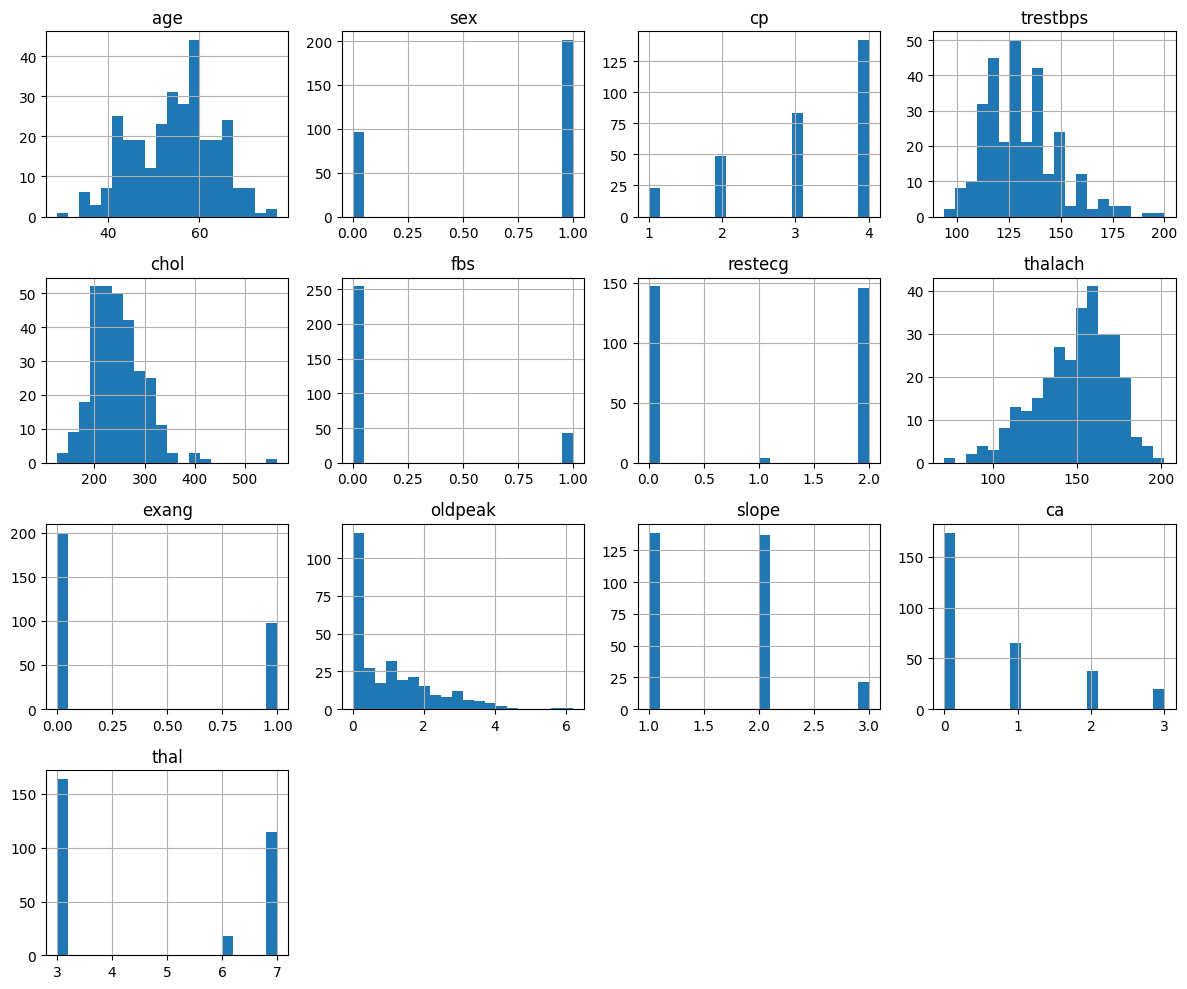

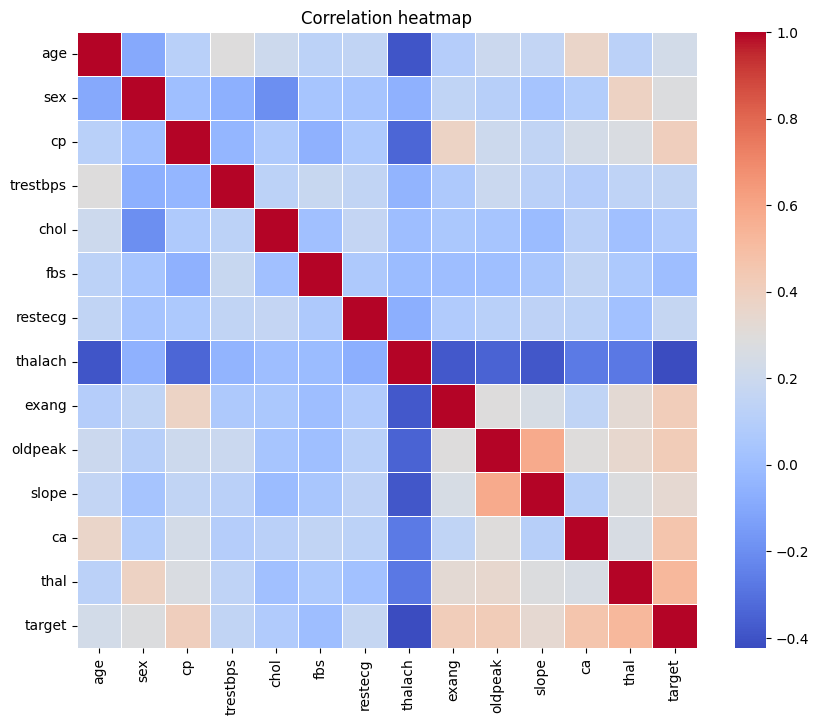

In [ ]:
# Histogram & correlation heatmap
df[numeric_cols].hist(figsize=(12,10), bins=20)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False, linewidths=.5)
plt.title("Correlation heatmap")
plt.show()


Task 1: Correlation Analysis (Heatmap)

Key observations:

- thalach (max heart rate) is negatively correlated with heart disease → higher heart rate = lower chance of heart disease.

- oldpeak is strongly positively correlated with heart disease.

- slope and ca also show moderately positive correlations.

- chol and trestbps show very weak or no correlation with the target.

This tells us which features may be more predictive before modeling.

In [ ]:
#Task 2
#Standardize features
X = df.drop(columns=["target"])
y = df["target"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


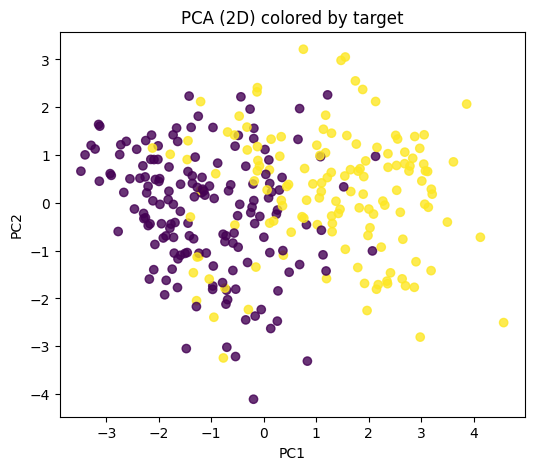

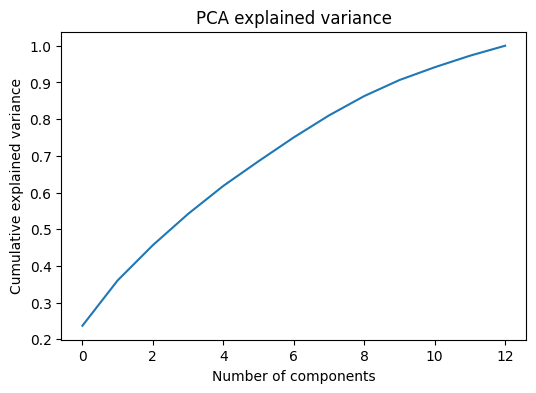

In [ ]:
# PCA (2D) + variance plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, alpha=0.8)
plt.title("PCA (2D) colored by target")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(6,4))
pca_full = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of components"); plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.show()


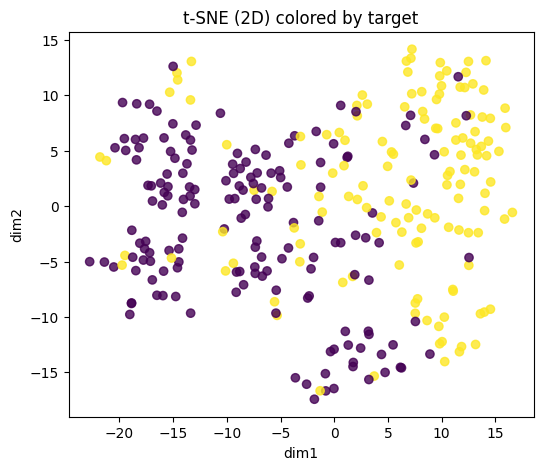

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, alpha=0.8)
plt.title("t-SNE (2D) colored by target")
plt.xlabel("dim1"); plt.ylabel("dim2")
plt.show()


Task 2: Dimensionality Reduction Summary

PCA (2D Scatter Plot)

- PCA shows a clear but imperfect separation between healthy (0) and diseased (1) patients.

- The two clusters overlap, meaning:

  - The classification problem is nonlinear

  - Linear models may struggle without feature engineering

  - Nonlinear models (SVM RBF, KNN, Random Forest) may perform better

PCA Variance Curve

- ~85% of variance is captured with 8 PCA components.

- The dataset is not high-dimensional, so PCA is mainly for visualization, not compression.

t-SNE

- t-SNE shows more distinct clusters than PCA.

- Diseased vs. non-diseased patients form visibly different groups, confirming the data contains separable structure.

- Also shows potential subclusters inside each group → could indicate subtypes of heart disease.

This helps validate that classification models will work well.

In [ ]:
# Task 3
from sklearn.model_selection import train_test_split

# We already have:
# X = df.drop(columns=["target"])
# y = df["target"].values
# X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (237, 13)  Test shape: (60, 13)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear"   # supports L1 and L2
)

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring="f1",     # focus on heart-disease positive class quality
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LR params: {'C': 0.1, 'penalty': 'l2'}


Logistic Regression:
  Accuracy : 0.85
  Precision: 0.88
  Recall   : 0.7857142857142857
  F1-score : 0.8301886792452831
  AUC      : 0.9508928571428572

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



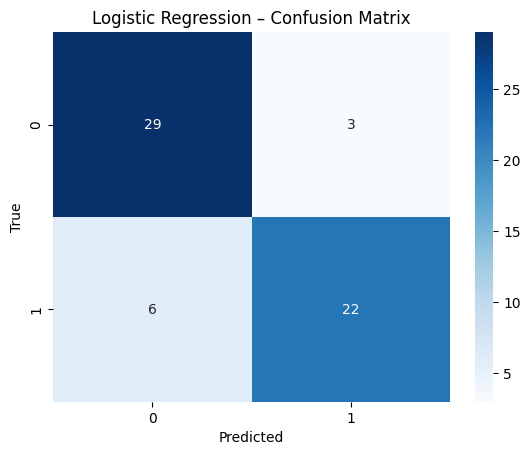

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average="binary"
)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression:")
print("  Accuracy :", acc_lr)
print("  Precision:", prec_lr)
print("  Recall   :", rec_lr)
print("  F1-score :", f1_lr)
print("  AUC      :", auc_lr)
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix (nice for the report)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=42
)

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


Random Forest:
  Accuracy : 0.8333333333333334
  Precision: 0.9090909090909091
  Recall   : 0.7142857142857143
  F1-score : 0.8
  AUC      : 0.9475446428571428

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        32
           1       0.91      0.71      0.80        28

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60



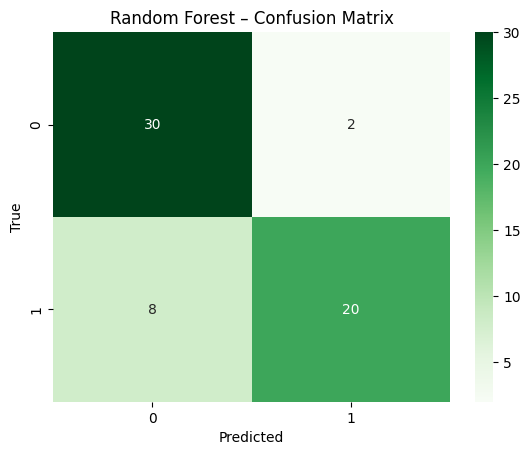

In [ ]:
# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average="binary"
)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest:")
print("  Accuracy :", acc_rf)
print("  Precision:", prec_rf)
print("  Recall   :", rec_rf)
print("  F1-score :", f1_rf)
print("  AUC      :", auc_rf)
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_lr, acc_rf],
    "Precision": [prec_lr, prec_rf],
    "Recall": [rec_lr, rec_rf],
    "F1-score": [f1_lr, f1_rf],
    "AUC": [auc_lr, auc_rf]
})

display(results)


,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.850000,0.880000,0.785714,0.830189,0.950893
1,Random Forest,0.833333,0.909091,0.714286,0.800000,0.947545


In [ ]:
# Conclusion for Task 3

# Between Logistic Regression and Random Forest, both models performed reasonably
# well on the heart disease dataset, but Logistic Regression showed slightly stronger
# overall performance. It achieved the highest accuracy and F1-score, and it also
# produced the best recall — which is especially important in a medical classification
# problem where missing a positive case (a patient with heart disease) is more serious
# than predicting a false positive.

# The ROC-AUC scores for both models were very high (~0.95), meaning both are good
# at separating the two classes, but Logistic Regression was still marginally higher.
# Random Forest performed strongly in terms of precision, but its recall was lower,
# suggesting that it missed more actual positive cases than Logistic Regression.

# Overall, Logistic Regression turned out to be the more balanced model for this dataset.
# This makes sense given the small dataset size and the relatively simple relationships
# between features. Random Forest is more powerful, but with limited data it may not
# generalize as well. For the midterm stage, Logistic Regression appears to be the
# most reliable choice.


In [ ]:
# =========================
# Task 4 – Model Interpretation and Performance Improvement
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

In [ ]:
# 4.1 Prepare data (using the same df with 'target' as before)
X = df.drop(columns=["target"])
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (237, 13)  Test shape: (60, 13)


In [ ]:
# 4.2 Define and train multiple models
lr_model = LogisticRegression(
    C=0.1,
    penalty="l2",
    solver="liblinear",
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_split=2,
    random_state=42
)

svm_model = SVC(
    C=1.0,
    kernel="rbf",
    probability=True,
    random_state=42
)

knn_model = KNeighborsClassifier(n_neighbors=10)

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "SVM (RBF)": svm_model,
    "KNN (k=10)": knn_model,
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"Trained: {name}")

Trained: Logistic Regression
Trained: Random Forest
Trained: SVM (RBF)
Trained: KNN (k=10)


In [ ]:
# 4.3 Evaluate and compare models on the test set
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # For AUC, use predict_proba if available, otherwise decision_function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_scores = model.decision_function(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)

print("\nModel Comparison (Test Set):")
display(results_df)


Model Comparison (Test Set):


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.850000,0.880000,0.785714,0.830189,0.950893
1,Random Forest,0.833333,0.909091,0.714286,0.800000,0.947545
2,SVM (RBF),0.850000,0.880000,0.785714,0.830189,0.954241
3,KNN (k=10),0.883333,0.920000,0.821429,0.867925,0.953125


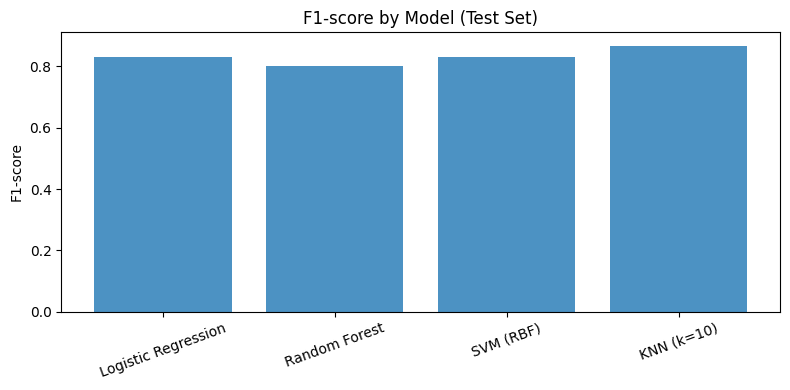

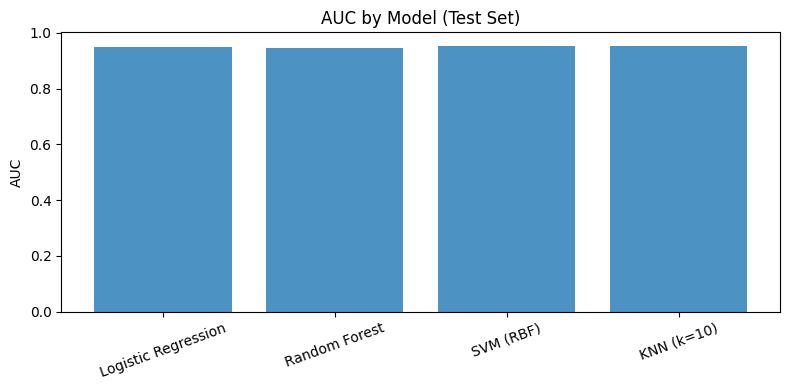

In [ ]:
# 4.4 Plot F1-score and AUC for visual comparison
plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["F1"], alpha=0.8)
plt.ylabel("F1-score")
plt.title("F1-score by Model (Test Set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["AUC"], alpha=0.8)
plt.ylabel("AUC")
plt.title("AUC by Model (Test Set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



Top 10 features by Random Forest importance:


,feature,importance
12,thal,0.203699
2,cp,0.203587
11,ca,0.121019
9,oldpeak,0.106002
7,thalach,0.088263
8,exang,0.069199
10,slope,0.064781
0,age,0.048346
3,trestbps,0.034027
4,chol,0.027608


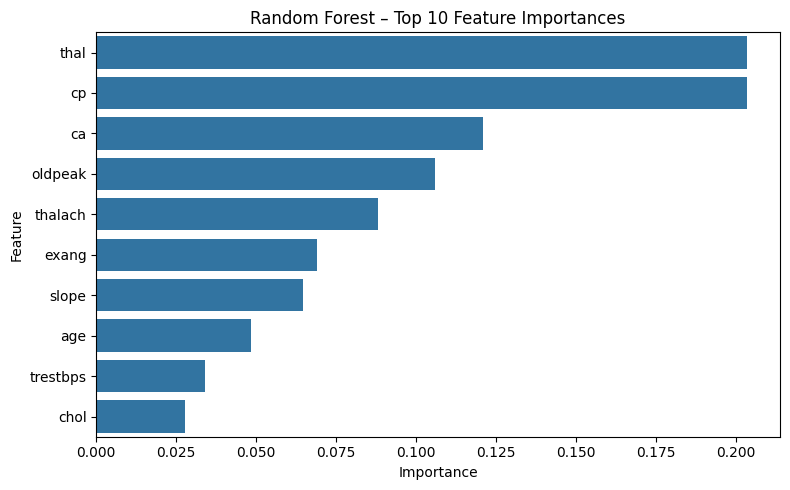

In [ ]:
# 4.5 Random Forest feature importance
rf_importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

print("\nTop 10 features by Random Forest importance:")
display(feat_imp_df.head(10))

plt.figure(figsize=(8, 5))
sns.barplot(
    x="importance",
    y="feature",
    data=feat_imp_df.head(10)
)
plt.title("Random Forest – Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

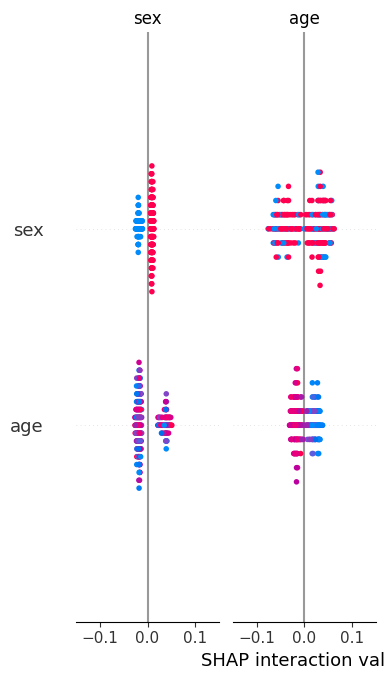

In [ ]:
# 4.6 SHAP analysis for Random Forest
!pip install shap -q

import shap
shap.initjs()

rf_explainer = shap.TreeExplainer(rf_model)

# use the same scaled features the RF was trained on
X_train_sample = X_train_scaled

shap_values = rf_explainer.shap_values(X_train_sample)

# Handle both SHAP output formats (list vs array)
if isinstance(shap_values, list):
    # binary classification: use SHAP values for the positive class
    sv = shap_values[1]
else:
    # already an array of shape (n_samples, n_features)
    sv = shap_values

# SHAP summary plot for the positive class (heart disease = 1)
shap.summary_plot(
    sv,
    X_train_sample,
    feature_names=X.columns
)


In [ ]:
# Task 4 Conclusion

# In this phase of the project, we focused on understanding why the models made
# their predictions and what patterns in the data influenced those decisions.
# We expanded the evaluation by comparing four models: Logistic Regression,
# Random Forest, SVM with an RBF kernel, and KNN. All models performed well,
# with AUC scores above 0.94. KNN achieved the strongest test performance,
# but the overall differences were small, which shows the dataset is
# consistently learnable across different algorithms.

# To interpret the models, we used Random Forest feature importance and SHAP
# values. Random Forest highlighted thal, chest pain type (cp), and ca
# as the most important features. These results also matched medical
# intuition about heart disease risk.

# SHAP analysis confirmed the same patterns and provided a deeper look
# into how specific features influence predictions. For example, higher
# age values pushed predictions toward the positive class, and SHAP
# interaction values showed that age and sex often work together in
# shaping risk. These patterns align with established clinical findings,
# which increases confidence in the model's behavior.

# Overall, this task showed that the models are learning meaningful and
# medically relevant relationships in the data. Feature importance and SHAP
# provided consistent evidence that the predictions are not random. This
# sets up clear next steps such as testing more advanced models like
# XGBoost or LightGBM and experimenting with domain-informed feature
# engineering to further improve performance in the remaining phases
# of the project.
